# AWB (Anwendungsbeobachtungen, Observational Studies)

This notebook reads in and cleans the received AWB data and shows some basic analysis.

In [1]:
from __future__ import division
import glob
from datetime import datetime, date, timedelta
import os
import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pandas as pd

import seaborn as sns

%matplotlib inline
matplotlib.rcParams['svg.fonttype'] = 'none'

pd.options.display.max_rows = 150

In [2]:
filenames = [('data/2004-2011.xlsx', range(2009, 2012)),
             ('data/2012-2014.xlsx', (2012, 2013, 2014))]


def read_excel(filename, years, kind='update', needle='Meldungen'):
    xl_file = pd.ExcelFile(filename)
    sheet_names = xl_file.sheet_names

    for year in years:
        sheet_name = [x for x in sheet_names if str(year) in x and needle in x][0]
        print(filename, sheet_name)
        df = xl_file.parse(sheet_name)
        # Make index into row number column
        df = df.reset_index()
        df['year'] = year
        df['row_type'] = kind
        df = df.rename(columns=dict([(x, x.strip()) for x in df.columns if x.strip() != x]))
        # Consolidate column names 
        df = df.rename(columns={u'Präparat': u'Präparatname',
                                u'Präparat/Titel der Anwendung': u'Präparatname',
                                u'gemeldet am': 'DatumErstanzeige',
                                u'Datum Erstanzeige': 'DatumErstanzeige',
                                u'Beobachtugsplan vorliegend': 'Beobachtungsplan vorliegend',
                                u'Ärzte gemeldet': u'gemeldete Ärzte',
                                u'Anzahl teilnehmende Ärzte (wenn angegeben)': u'gemeldete Ärzte',
                                u'Anzahl der beobachtenden Ärzte': u'beobachtende Ärzte',
                                'index': 'row_number'
                               })
        if 'DatumErstanzeige' not in df.columns:
            df = df.rename(columns={'Eingang': 'DatumErstanzeige'})
        # Fix date columns
        date_cols = list(df.columns[df.columns.str.startswith('Datum')])
        for x in date_cols:
            df['dt_%s' % x] = pd.to_datetime(df[x], errors='coerce')
        df[u'Präparatname'] = df[u'Präparatname'].str.strip()
        # Remove entries with empty drug name
        df = df[df[u'Präparatname'].notnull()]
        yield df


First, read in all available update messages.

In [3]:
num_cols = ['Patienten geplant', 'Patienten beobachtet', u'gemeldete Ärzte', u'beobachtende Ärzte',
            u'Vertragsärzte', u'Aufwandsentschädigung pro Patient']
float_cols = [u'Aufwandsentschädigung pro Patient']

In [4]:
df_updates = pd.concat(itertools.chain(*[read_excel(*args) for args in filenames]))

# To be compatible with Abschluesse column
df_updates['Aufwandsentschädigung gesamt in €'] = None

print('Number of rows', len(df_updates))
df_updates.head()

data/2004-2011.xlsx Meldungen 2009 Gesamt
data/2004-2011.xlsx Meldungen 2010 Gesamt
data/2004-2011.xlsx Meldungen 2011 Gesamt
data/2012-2014.xlsx 2012 Meldungen gesamt
data/2012-2014.xlsx 2013 Meldungen gesamt
data/2012-2014.xlsx 2014 Meldungen gesamt
Number of rows 13829


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Art der NIS,Auftraggeber,Aufwandsentschädigung Kommentar,Aufwandsentschädigung pro Patient,Beobachtungsplan vorliegend,BeobachtungszeitraumKommentar,Brief/Mail/Fax,DatumAbmeldung,DatumBrief,DatumEingang,...,dt_DatumBrief,dt_DatumEingang,dt_DatumEnde,dt_DatumErstanzeige,dt_DatumStart,gemeldete Ärzte,row_number,row_type,year,Aufwandsentschädigung gesamt in €
0,NaN,NaN,pro vollständig ausgefüllten Dokumentationsbog...,900,NaN,NaN,eMail,NaT,NaT,2009-01-06 00:00:00,...,NaT,2009-01-06,2009-04-30,2008-09-19,2008-04-01,NaN,0,update,2009,None
1,NaN,NaN,"pro vollständig dokumentierter Eingangsvisite,...",150,NaN,NaN,eMail,NaT,NaT,2009-01-06 00:00:00,...,NaT,2009-01-06,2009-12-31,2006-07-25,2006-07-27,NaN,1,update,2009,None
2,NaN,NaN,Meldung vor Anzeigenpflicht,NaN,NaN,NaN,eMail,NaT,NaT,2009-01-06 00:00:00,...,NaT,2009-01-06,2008-12-31,2005-10-11,2005-10-11,NaN,2,update,2009,None
3,NaN,NaN,Meldung vor Anzeigenpflicht,NaN,NaN,NaN,eMail,NaT,NaT,2009-01-06 00:00:00,...,NaT,2009-01-06,2009-12-31,2007-02-27,2007-03-01,NaN,3,update,2009,None
4,NaN,NaN,NaN,20,NaN,NaN,eMail,NaT,NaT,2009-01-06 00:00:00,...,NaT,2009-01-06,2009-04-30,2008-04-01,2008-04-01,NaN,4,update,2009,None


In [5]:
# Catch bogus row that is way down and contains a different header
# Interesting colum "HonorarPlausibilität" (plausibility of fee) which is not available in our dataset
bad_series = df_updates[df_updates['Art der NIS'] == 'Art der NIS'].T.iloc[:,0]
# Remove the row before processing further
df_updates = df_updates[~(df_updates['Art der NIS'] == 'Art der NIS')]
bad_series

Art der NIS                                                 Art der NIS
Auftraggeber                                               Auftraggeber
Aufwandsentschädigung Kommentar                 Anzahl der Ärzte Gesamt
Aufwandsentschädigung pro Patient                       AnzahlPatienten
Beobachtungsplan vorliegend                        HonorarPlausibilität
BeobachtungszeitraumKommentar             BeobachtungszeitraumKommentar
Brief/Mail/Fax                                             DatumEingang
DatumAbmeldung                                              Meldungsart
DatumBrief                                               Brief/Mail/Fax
DatumEingang                                                        ATC
DatumEnde                                                     DatumEnde
DatumErstanzeige                                       DatumErstanzeige
DatumStart                                                   DatumStart
Firma                                                           

Read in all final notices.

In [6]:
abschluesse_df = pd.concat(itertools.chain(*[read_excel(*args, needle='Abschl', kind='final') for args in filenames]))

abschluesse_df

# Make columns compatible with update notices
columns = u'dt_DatumErstanzeige	dt_DatumStart	dt_DatumEingang	Präparatname	Wirkstoff	Firma	Patienten beobachtet	Patienten geplant	beobachtende Ärzte	gemeldete Ärzte	Aufwandsentschädigung pro Patient	Aufwandsentschädigung Kommentar	Aufwandsentschädigung gesamt in €	Art der NIS	Auftraggeber	Beobachtungsplan vorliegend	BeobachtungszeitraumKommentar	Brief/Mail/Fax	DatumAbmeldung	DatumBrief	DatumEingang	DatumEnde	Kommentar	MeldungsGrund	MeldungsKommentar	Meldungsart	Meldungsinhalt	Titel (Ziel)	Typ	Vertrag vorliegend	Vertragsärzte	dt_DatumAbmeldung	dt_DatumBrief	dt_DatumEnde	year'.split('\t')
for c in columns:
    if c not in abschluesse_df:
        abschluesse_df[c] = None

print('Number of rows', len(abschluesse_df))
abschluesse_df.head()

data/2004-2011.xlsx Abschlüsse 2009
data/2004-2011.xlsx Abschlüsse 2010
data/2004-2011.xlsx Abschlüsse 2011
data/2012-2014.xlsx 2012 Abschlüsse
data/2012-2014.xlsx 2013 Abschlüsse
data/2012-2014.xlsx 2014 Abschlüsse
Number of rows 365


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Art der NIS,Auftraggeber,Aufwandsentschädigung Kommentar,Aufwandsentschädigung gesamt in €,Aufwandsentschädigung pro Patient,Beobachtungsplan vorliegend,BeobachtungszeitraumKommentar,Brief/Mail/Fax,DatumAbmeldung,DatumBrief,...,dt_DatumAbmeldung,dt_DatumBrief,dt_DatumEingang,dt_DatumEnde,dt_DatumErstanzeige,dt_DatumStart,gemeldete Ärzte,row_number,row_type,year
0,NaN,NaN,keine Aufwandsentschädigung angegeben,k.A.,NaN,NaN,NaN,Brief,NaT,2009-01-06 00:00:00,...,NaT,2009-01-06,2009-01-09,2008-01-09,2006-02-14,2006-02-14,NaN,0,final,2009
1,NaN,NaN,pro Patient,97743.2,80,NaN,NaN,eMail,NaT,NaT,...,NaT,NaT,2009-01-19,2008-07-31,2007-10-31,2007-10-01,NaN,1,final,2009
2,NaN,NaN,keine Aufwandsentschädigung angegeben,k.A.,NaN,NaN,NaN,Brief,NaT,2009-01-09 00:00:00,...,NaT,2009-01-09,2009-01-14,2011-09-01,2008-03-12,2008-03-01,12 (letzte Meldung),2,final,2009
3,NaN,Janssen-Cilag GmbH,pro dokumentierten Patienten,k.A.,75,NaN,11.04.08 - 14.01.09,Brief,NaT,2009-01-14 00:00:00,...,NaT,2009-01-14,2009-01-16,2009-01-14,2009-04-11,NaT,65 (letzte Meldung),3,final,2009
4,NaN,NaN,pro Patient,k.A.,90,NaN,Sep. 2006 - März 2007,Brief,NaT,2009-01-13 00:00:00,...,NaT,2009-01-13,2009-01-16,NaT,2006-08-25,NaT,NaN,4,final,2009


In [7]:
# Same as before, remove bogus header row at line 12607 of final notices in year 2013
bad_series = abschluesse_df[abschluesse_df['Art der NIS'] == 'Art der NIS'].T.iloc[:,0]
# Remove the row before processing further
abschluesse_df = abschluesse_df[~(abschluesse_df['Art der NIS'] == 'Art der NIS')]
bad_series

Art der NIS                                                 Art der NIS
Auftraggeber                                               Auftraggeber
Aufwandsentschädigung Kommentar                 Anzahl der Ärzte Gesamt
Aufwandsentschädigung gesamt in €                                   NaN
Aufwandsentschädigung pro Patient                       AnzahlPatienten
Beobachtungsplan vorliegend                        HonorarPlausibilität
BeobachtungszeitraumKommentar             BeobachtungszeitraumKommentar
Brief/Mail/Fax                                             DatumEingang
DatumAbmeldung                                              Meldungsart
DatumBrief                                               Brief/Mail/Fax
DatumEingang                                                        ATC
DatumEnde                                                     DatumEnde
DatumErstanzeige                                       DatumErstanzeige
DatumStart                                                   Dat

Get cleaner number representation of total amount.

In [8]:
import re
import numbers

NUMBER_RE = re.compile('^\s*([\d\., ]+)')
NUMBERS_RE = {
    re.compile(r'^([\d\.]+),(\d{1,2}]+)'): '.',
    re.compile(r'^([\d,]+)\.(\d{1,2}]+)'): ',',
}

def clean_money(x):
    if isinstance(x, numbers.Number):
        return x
    x = NUMBER_RE.sub('\\1', x)
    for reg, repl in NUMBERS_RE.items():
        m = reg.search(x)
        if m is None:
            continue
        before = int(m.group(1).replace(repl, ''))
        after = int(m.group(2))
        if after < 10:
            after = after / 10.0
        else:
            after = after / 100.0
        return before + after
    return None
    
abschluesse_df['Aufwandsentschädigung gesamt'] = abschluesse_df['Aufwandsentschädigung gesamt in €'].apply(clean_money)
abschluesse_df[['Aufwandsentschädigung gesamt', 'Aufwandsentschädigung gesamt in €']].head()

,Aufwandsentschädigung gesamt,Aufwandsentschädigung gesamt in €
0,NaN,k.A.
1,97743.2,97743.2
2,NaN,k.A.
3,NaN,k.A.
4,NaN,k.A.


In [9]:
# Added by Steve
abschluesse_df.loc[:,['Aufwandsentschädigung gesamt in €','Aufwandsentschädigung gesamt']]

,Aufwandsentschädigung gesamt in €,Aufwandsentschädigung gesamt
0,k.A.,NaN
1,97743.2,97743.20
2,k.A.,NaN
3,k.A.,NaN
4,k.A.,NaN
5,k.A.,NaN
6,k.A.,NaN
7,k.A.,NaN
8,k.A.,NaN
9,k.A.,NaN


In [10]:
grouper = ['dt_DatumErstanzeige', 'dt_DatumStart']

# Fill missing values in grouping columns with dummy value,
# so it's not silently dropped by pandas groupby
dummy_date = pd.to_datetime(date(1900, 1, 1))
abschluesse_df[grouper] = abschluesse_df[grouper].fillna(dummy_date)
df_updates[grouper] = df_updates[grouper].fillna(dummy_date)

assert not abschluesse_df[grouper].isnull().any().any()
assert not df_updates[grouper].isnull().any().any()

Combine update notices and final notices.

In [11]:
df_all = pd.concat([df_updates, abschluesse_df])
df_all = df_all.reset_index(drop=True)

df_all['row_type'].value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


update    13828
final       364
Name: row_type, dtype: int64

In [12]:
# Add simpler version of präparatname that might group better later

DRUG_NAME_SPLITTER = re.compile(r'[^\w ]|\d|_', re.U | re.I)

def clean_praeparat(praeparat):
    name = DRUG_NAME_SPLITTER.split(praeparat)[0].strip().lower()
    if len(name) < 4:
        return praeparat
    return name


df_all['praeparat'] = df_all[u'Präparatname'].apply(clean_praeparat)

print('Original Präparatname Number of Groups', len(df_all[u'Präparatname'].value_counts()))
print('Cleaned Präparatname Number of Groups', len(df_all['praeparat'].value_counts()))

Original Präparatname Number of Groups 997
Cleaned Präparatname Number of Groups 813


In [42]:
# Added by Steve,

df_all[u'Präparatname']

0                                           Kogenate Bayer 250, 500, 1000, 2000
1                                                                       Nexavar
2                                                                        Avalox
3                                                                       Levitra
4                                                                     Ultravist
5                                                                       Nexavar
6                                                   Xelevia 100mg Filmtabletten
7                                                                      Revlimid
8                                                                       Argatra
9                                                            Epoetin alfa HEXAL
10                                                                        Fluad
11                                                              Haemocomplettan
12                                      

In [13]:
for name in num_cols:
    new_name = 'num_%s' % name
    df_all[new_name] = df_all[name].copy()
    df_all[new_name] = df_all[new_name].apply(str)
    
    if name not in float_cols:
        df_all[new_name] = (df_all[new_name]
                        .str.replace('(geplante Anzahl *:?|ca\.|max\.|geplant *:)', '', flags=re.I)
                        .str.strip()
                        .str.replace(r'[ ,\.]', '')
        )
    df_all[new_name] = (df_all[new_name]
                    .str.replace('^\d+-(\d+)$', '\\1')
    )
    if name not in float_cols:
        df_all[new_name] = (df_all[new_name]
            .str.replace(r'^(\d+).*', '\\1', flags=re.I)
        )
    df_all[new_name] = pd.to_numeric(df_all[new_name], errors='coerce')


In [14]:
# Check if cleaning kind of worked
df_all[df_all['Patienten geplant'].str.contains(' ').fillna(False)][['Patienten geplant', 'num_Patienten geplant']].sample(10)

,Patienten geplant,num_Patienten geplant
5435,ca. 400,400.0
578,36 000,36000.0
1944,ca. 400,400.0
10492,max. 999,999.0
2386,350 Patienten,350.0
2587,15000 Patienten,15000.0
2435,1800 Patienten,1800.0
2301,20 Patienten,20.0
4400,ca. 400,400.0
4397,ca. 400,400.0


## Analysis

Here's some exploratory analysis around the dataset.

First step is to group the single update and final notices into observational studies (AWB).
We define the identification of one AWB to be the combination of its drug name, its registration date and its start date.

Per group of notices we find maxmimal numeric values for certain key figures and take the most prominent or last value for other columns.

In [15]:
def get_best_value(series):
    vc = series.value_counts()
    if len(vc) == 0:
        lvi = series.last_valid_index()
        if lvi is None:
            return None
        return series[lvi]
    return vc.idxmax()

def get_awbs(groups):

    for key, rows in groups:
        # Use maximum number across columns and rows for one AWB
        patient_count = rows[['num_Patienten beobachtet', 'num_Patienten geplant']].max().max()
        doc_count = rows[['num_beobachtende Ärzte', 'num_gemeldete Ärzte']].max().max()
        fee_per_patient = rows[[u'num_Aufwandsentschädigung pro Patient']].max().max()
        
        yield pd.DataFrame([{
                'praeparat': key[0],
                'Präparatname': get_best_value(rows['Präparatname']),
                'dt_DatumErstanzeige': key[1],
                'dt_Start': key[2],
                'patient_count': patient_count,
                'doc_count': doc_count,
                'fee_per_patient': fee_per_patient,
                'calculated_total_fee': fee_per_patient * patient_count,
                'fee_comment': get_best_value(rows['Aufwandsentschädigung Kommentar']),
                'final_total_fee': rows['Aufwandsentschädigung gesamt'].max(),
                # Use most used values across AWB rows
                'Auftraggeber': get_best_value(rows['Auftraggeber']),
                'Firma': get_best_value(rows['Firma']),
                'Wirkstoff': get_best_value(rows['Wirkstoff']),
                'dt_DatumEnde': get_best_value(rows['dt_DatumEnde']),
            }])


awb_grouper = ['praeparat', 'dt_DatumErstanzeige', 'dt_DatumStart']
groups = df_all.sort_values(['dt_DatumEingang']).groupby(awb_grouper)
df_awb = pd.concat(get_awbs(groups))
df_awb = df_awb.reset_index(drop=True)
df_awb.head()

,Auftraggeber,Firma,Präparatname,Wirkstoff,calculated_total_fee,doc_count,dt_DatumEnde,dt_DatumErstanzeige,dt_Start,fee_comment,fee_per_patient,final_total_fee,patient_count,praeparat
0,None,LA-SER Europe Ltd.,(diverse Antiarrhythmika),kein spezieller Wirkstoff,500000.0,NaN,2015-06-30 00:00:00,2012-12-19,2013-01-01,für jeden abgeschlossenen und auswertbaren Fall,1250.0,NaN,400.0,(diverse Antiarrhythmika)
1,Lilly Deutschland GmbH,ICON plc (CRO),"(diverse Präparate), Alimta",diverse Wirkstoffe,193200.0,94.0,2012-07-31 00:00:00,2009-06-16,2009-04-17,max. 400 € pro Patient (aufgelistet im Vertrag),400.0,NaN,483.0,"(diverse Präparate), Alimta"
2,Novartis Pharma GmbH,Lungenforschung,", Ultibro","Glycopyrroniumbromid, Indacaterol",5040000.0,562.0,2015-07-31 00:00:00,2012-10-30,2012-11-02,pro vollständig dokumentiertem Patienten,420.0,NaN,12000.0,", Ultibro"
3,Beiersdorf AG,GKM Gesellschaft für Therapieforschung mbH,ABC® Wärme-Pflaster Capsicum 11 mg,Dickextrakt aus Cayennepfeffer (4-7:1) entspre...,20000.0,170.0,2014-06-30 00:00:00,2013-12-13,2013-12-16,2 Visiten,80.0,19168.0,250.0,ABC® Wärme-Pflaster Capsicum 11 mg
4,None,IAS Dr. Jörg Schnitker GmbH,ALK-depot SQ 200,gereinigte Allergene aus verschiedenen Pollen,162000.0,NaN,2009-09-30 00:00:00,2009-05-07,2009-05-08,pro Patient,180.0,NaN,900.0,ALK-depot SQ 200


Number of extracted AWBs

In [16]:
len(df_awb)

1589

### Numbers of patients

In [17]:
df_awb['patient_count'].sum()

5270426.0

In [18]:
df_awb['patient_count'].describe()

count    1.120000e+03
mean     4.705738e+03
std      5.105983e+04
min      0.000000e+00
25%      2.000000e+02
50%      5.000000e+02
75%      1.500000e+03
max      1.500000e+06
Name: patient_count, dtype: float64

### Numbers of doctors

In [19]:
df_awb['doc_count'].sum()

769844.0

In [20]:
df_awb['doc_count'].describe()

count      868.000000
mean       886.917051
std       2615.096255
min          0.000000
25%         50.000000
50%        215.000000
75%        822.500000
max      61500.000000
Name: doc_count, dtype: float64

### Fee per Patient

In [21]:
df_awb['fee_per_patient'].describe()

count    1409.000000
mean      505.490823
std       686.699514
min         0.000000
25%       100.000000
50%       300.000000
75%       650.000000
max      7280.000000
Name: fee_per_patient, dtype: float64

In [22]:
df_awb['final_total_fee'].describe()

count    1.200000e+02
mean     2.172665e+05
std      5.370101e+05
min      0.000000e+00
25%      1.443000e+04
50%      5.621250e+04
75%      1.852567e+05
max      4.984295e+06
Name: final_total_fee, dtype: float64

## How many AWBs over the years?

In [23]:
awbs_per_year = df_awb.groupby(df_awb.dt_DatumErstanzeige.dt.year).size()

# Drop stupid values
awbs_per_year = awbs_per_year.drop([1900, 1905])
awbs_per_year

dt_DatumErstanzeige
2000      1
2001      1
2002      1
2003      5
2004      7
2005     19
2006     55
2007     71
2008    153
2009    245
2010    249
2011    202
2012    219
2013    156
2014    173
dtype: int64

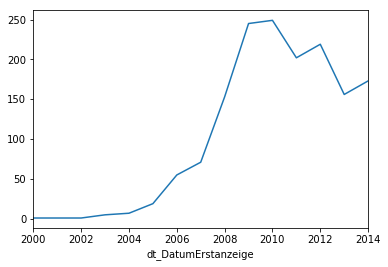

In [24]:
awbs_per_year.plot()

## How many patients were in the studies over the years?

In [25]:

patients_per_year = df_awb.groupby(df_awb.dt_Start.dt.year)['patient_count'].sum()
patients_per_year

dt_Start
1900      34978.0
1987          0.0
1993          0.0
1995       1000.0
1996          0.0
1999      36000.0
2000       3402.0
2001        400.0
2003         36.0
2004      52009.0
2005      14397.0
2006      33757.0
2007      45020.0
2008     216901.0
2009    1939378.0
2010     456893.0
2011    1365986.0
2012     494402.0
2013     442075.0
2014     133187.0
2015        605.0
Name: patient_count, dtype: float64

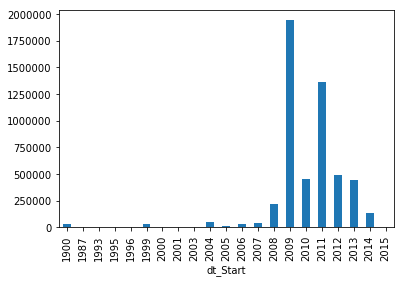

In [26]:
patients_per_year.plot(kind='bar')

## How many doctors participated over the years?

In [27]:
doctors_per_year = df_awb.groupby(df_awb.dt_Start.dt.year)['doc_count'].sum()
doctors_per_year

dt_Start
1900     11385.0
1987      2020.0
1993      1240.0
1995         0.0
1996         0.0
1999      1380.0
2000       440.0
2001        10.0
2003       370.0
2004      1694.0
2005       241.0
2006     27014.0
2007     19940.0
2008     44914.0
2009    101600.0
2010    157077.0
2011    102957.0
2012    138402.0
2013     98724.0
2014     60236.0
2015       200.0
Name: doc_count, dtype: float64

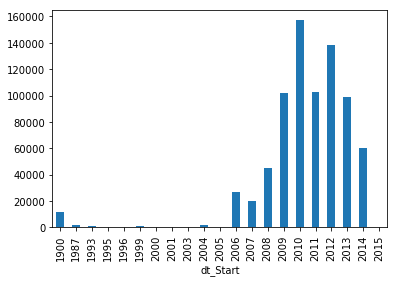

In [28]:
doctors_per_year.plot(kind='bar')

In [29]:
awbv = ['Auftraggeber', 'Firma', 'Präparatname', 'doc_count', 'patient_count', 'final_total_fee', 'fee_per_patient',
        'fee_comment', 'calculated_total_fee', 'praeparat', 'Wirkstoff', 'dt_DatumEnde', 'dt_DatumErstanzeige',
        'dt_Start']

## Highest patient count

In [30]:
df_awb.sort_values('patient_count', ascending=False).head(10)[awbv]

,Auftraggeber,Firma,Präparatname,doc_count,patient_count,final_total_fee,fee_per_patient,fee_comment,calculated_total_fee,praeparat,Wirkstoff,dt_DatumEnde,dt_DatumErstanzeige,dt_Start
1533,None,Guerbet GmbH,Xenetix 250/300/350,1830.0,1500000.0,1136800.0,10.00,pro ausgefülltem Dokumentationsbogen,15000000.0,xenetix,"Iobitridol 548,4/658,1/767,8 mg/ml",2011-12-31 00:00:00,2009-07-24,2009-08-01
329,None,Guerbet GmbH,Dotarem,64.0,750000.0,450110.0,10.00,Euro pro ordnungsgemäß ausgefüllten Patientenb...,7500000.0,dotarem,"Gadoterat-Meglumin 0,5 mmol/ml,",2013-12-31 00:00:00,2010-12-08,2011-01-01
1246,None,Daiichi Sankyo,Sevikar,NaN,153610.0,NaN,60.00,pro Patient / opt. 30 und 12 EUR für 2x Ausfül...,9216600.0,sevikar,Olmesartan+Amlodipin,2010-12-13 00:00:00,2009-01-16,2009-01-05
826,None,Agfa HealthCare Imaging Agents GmbH,Magnegita,0.0,150000.0,NaN,15.00,pro Patient und vollständiger Dokumentation,2250000.0,magnegita,Gadopentetat -Dimeglumin,2015-04-30 00:00:00,2013-04-30,2013-05-01
1248,Daiichi Sankyo Deutschland GmbH,"INC Research, vorher Kendle GmbH",Sevikar HCT,18920.0,130000.0,525560.0,90.00,max. (siehe Vertrag),11700000.0,sevikar hct,Olmesartanmedoxomil + Amlodipin (als Amlodipin...,2012-08-31 00:00:00,2011-04-28,2011-05-10
947,"CHDI Foundation, Inc.",Quintiles GmbH,nicht zutreffend,NaN,100000.0,NaN,576.15,"Baseline, Follow-up: 407,96€",57615000.0,nicht zutreffend,nicht zutreffend,2025-09-01 00:00:00,2013-04-25,2013-09-01
331,None,Guerbet GmbH,Dotarem,150.0,100000.0,30480.0,20.00,Euro pro ordnungsgemäß ausgefüllten Patientenb...,2000000.0,dotarem,"Gadoterat-Meglumin 0,5 mmol/ml,",2013-06-30 00:00:00,2011-08-25,2011-09-01
69,Chiesi Farmaceutici S.p.A.,Pierrel Research,alle zugelassenen Anti-Asthma Therapien,240.0,81500.0,NaN,200.00,max. pro Patient,16300000.0,alle zugelassenen anti,diverse,2014-05-31 00:00:00,2012-06-22,2012-04-01
1249,Daiichi Sankyo Deutschland GmbH,CFC - Stolberg,Sevikar HCT,1436.0,65000.0,447500.0,90.00,max. (70 € pro Patient + 20 € für 2 Patientenb...,5850000.0,sevikar hct,Olmesartanmedoxomil+Amlodipin+Hydrochlorothiazid,2013-12-31 00:00:00,2012-11-22,2012-11-22
351,None,Takeda Pharma GmbH,Edarbi,4380.0,50000.0,409550.0,150.00,3 Visiten à 50€,7500000.0,edarbi,Azilsartan,2013-12-31 00:00:00,2012-01-20,2012-01-15


## Highest fee per patient

In [31]:
df_awb.sort_values('fee_per_patient', ascending=False).head(10)[awbv]

,Auftraggeber,Firma,Präparatname,doc_count,patient_count,final_total_fee,fee_per_patient,fee_comment,calculated_total_fee,praeparat,Wirkstoff,dt_DatumEnde,dt_DatumErstanzeige,dt_Start
253,Merck Serono SA-Geneva,Outcome Europe Sarl (CRO),Cladribine,NaN,2000.0,NaN,7280.0,"für einen Zeitraum von 8 Jahren ,pro Patient",14560000.0,cladribine,Cladribine,2018-12-31 00:00:00,2010-03-18,2010-04-01
66,Pfizer Pharma GmbH,Parexel International GmbH,alle mit Latanoprost sowie nicht-Latanoprost-h...,10.0,14.0,NaN,7200.0,8 Visiten über 8 Jahre à 970€,100800.0,alle mit latanoprost sowie nicht,Latanoprost,2023-01-01 00:00:00,2014-12-19,2015-01-01
928,Schwarz Pharma Deutschland GmbH,UCB Biosciences GmbH,Neupro transdermales Pflaster,100.0,NaN,NaN,6400.0,"max.6400 € (8 Patienten a 800 €), aufgeschlüss...",NaN,neupro transdermales pflaster,Rotigotin,None,2006-06-29,1900-01-01
1384,Pfizer Pharma GmbH,Winicker Norimed GmbH,"Torisel, Sutent, Inlyta",1890.0,1600.0,NaN,5655.0,pro Patient und vollständigem Dokumentationsbogen,9048000.0,torisel,"Temsirolimus, Sunitinib, Axtinib",2016-01-01 00:00:00,2012-12-21,2008-01-01
626,None,AbbVie Deutschland GmbH & Co. KG,HUMIRA,110.0,NaN,NaN,4609.0,16 Visiten (288€ pro Visite),NaN,humira,Adalimumab,2023-12-31 00:00:00,2009-12-09,2010-01-01
625,None,Abbott GmbH & Co. KG,HUMIRA 40 mg,NaN,NaN,NaN,4609.0,pro vollständig dokumentiertem Patienten ( 16 ...,NaN,humira,Adalimumab,2020-01-01 00:00:00,2009-12-01,2010-01-01
942,Chiesi,CROMSOURCE GmbH,nicht-medikamentöse Beobachtungsstudie,30.0,89.0,NaN,4600.0,"4 Visiten à 1100€, 2 Telefonate á 100€",409400.0,nicht,None,2016-10-31 00:00:00,2014-07-01,2014-06-30
645,Alimera Sciences Limited,medicomp,Iluvien,80.0,800.0,NaN,4250.0,"18 Dokumentationen: Einschlussvisite: 750€, Ta...",3400000.0,iluvien,Fluocinolonacetonid,2019-04-01 00:00:00,2014-03-19,2014-03-20
636,Baxter Innovations GmbH/Wien,Baxter Innovations GmbH/Wien,HyQvia,110.0,42.0,NaN,3913.0,24 Visiten über 6 Jahre à 150€,164346.0,hyqvia,Normales Immunglobulin vom Menschen (IG 10 %),2020-07-17 00:00:00,2014-07-16,2014-07-17
239,Baxter Healthcare,Dabio (MAPI S.A.S),Ceprotin,60.0,40.0,NaN,3785.0,"27 Visiten in 4,5 Jahren",151400.0,ceprotin,Ceprotin,2016-08-31 00:00:00,2011-10-06,2011-09-15


## Highest calculated total fee (fee per patient times number of patients)

In [32]:
df_awb.sort_values('calculated_total_fee', ascending=False).head(10)[awbv]

,Auftraggeber,Firma,Präparatname,doc_count,patient_count,final_total_fee,fee_per_patient,fee_comment,calculated_total_fee,praeparat,Wirkstoff,dt_DatumEnde,dt_DatumErstanzeige,dt_Start
947,"CHDI Foundation, Inc.",Quintiles GmbH,nicht zutreffend,NaN,100000.0,NaN,576.15,"Baseline, Follow-up: 407,96€",57615000.0,nicht zutreffend,nicht zutreffend,2025-09-01 00:00:00,2013-04-25,2013-09-01
804,Novartis Pharma GmbH,clinicalmonitor (Quintiles),Lucentis,200.0,30000.0,NaN,725.25,"max. pro Patient (über 5 Jahre, siehe Vertrag)",21757500.0,lucentis,Ranibizumab,2016-03-21 00:00:00,2011-10-19,2011-03-21
805,None,Novartis Pharma GmbH,Lucentis,210.0,30000.0,NaN,725.25,"max. pro Patient (über 5 Jahre, siehe Vertrag)",21757500.0,lucentis,Ranibizumab,2016-12-31 00:00:00,2011-10-19,2011-11-01
809,Novartis Pharma GmbH,Kantar Health GmbH,Lucentis,NaN,20000.0,NaN,1045.00,"max. pro Patient, aufgelistet im Vertrag",20900000.0,lucentis,Ranibizumab,2014-04-30 00:00:00,2011-11-30,2011-12-05
1069,None,Roche Pharma AG,Pegasys,6000.0,9790.0,NaN,1762.68,pro ordnungsgemäß ausgefüllter Patientendokume...,17256637.2,pegasys,PegInterferon alpha-2a,2016-12-31 00:00:00,2011-10-17,2011-10-04
69,Chiesi Farmaceutici S.p.A.,Pierrel Research,alle zugelassenen Anti-Asthma Therapien,240.0,81500.0,NaN,200.00,max. pro Patient,16300000.0,alle zugelassenen anti,diverse,2014-05-31 00:00:00,2012-06-22,2012-04-01
999,Thrombosis Research Institute (UK),Parexel International GmbH,orale + andere Antikoagulanzien,NaN,50000.0,NaN,300.00,Pfund Sterling (GBP) pro retrospektivem Patien...,15000000.0,orale,orale + andere Antikoagulanzien,2016-06-03 00:00:00,2010-06-03,2010-06-04
1533,None,Guerbet GmbH,Xenetix 250/300/350,1830.0,1500000.0,1136800.0,10.00,pro ausgefülltem Dokumentationsbogen,15000000.0,xenetix,"Iobitridol 548,4/658,1/767,8 mg/ml",2011-12-31 00:00:00,2009-07-24,2009-08-01
943,Thrombosis Research Institute (UK),Parexel International GmbH,nicht zutreffend,NaN,50000.0,NaN,300.00,Pfund Sterling (GBP) pro retrospektivem Patien...,15000000.0,nicht zutreffend,k.A.,2016-06-03 00:00:00,2010-06-03,2010-06-04
253,Merck Serono SA-Geneva,Outcome Europe Sarl (CRO),Cladribine,NaN,2000.0,NaN,7280.00,"für einen Zeitraum von 8 Jahren ,pro Patient",14560000.0,cladribine,Cladribine,2018-12-31 00:00:00,2010-03-18,2010-04-01


## Highest total final costs per AWB

In [33]:
df_awb.sort_values('final_total_fee', ascending=False).head(10)[awbv]

,Auftraggeber,Firma,Präparatname,doc_count,patient_count,final_total_fee,fee_per_patient,fee_comment,calculated_total_fee,praeparat,Wirkstoff,dt_DatumEnde,dt_DatumErstanzeige,dt_Start
611,None,Abbott GmbH & Co. KG,HUMIRA 40 mg,3510.0,5000.0,4984295.00,150.00,pro Patient und pro Visite,750000.0,humira,Adalimumab,2016-06-01 00:00:00,2006-06-12,2006-06-01
101,None,AMGEN GmbH,Aranesp,620.0,950.0,2016638.00,NaN,Meldung vor Anzeigenpflicht,NaN,aranesp,Darbepoetin alfa,2013-05-31 00:00:00,2007-02-26,2007-03-01
1352,None,Sanofi-Aventis Deutschland GmbH,Taxotere,4530.0,40000.0,1425312.75,15.00,pro Dok./Seite,600000.0,taxotere,Docetaxel,2011-02-28 00:00:00,2008-12-29,2009-01-01
203,None,Roche Pharma AG,"Bonviva , Fosamax , diverse Alendronat-Generika",2000.0,6009.0,1299733.75,240.00,"pro Patient , aufgeschlüsselt im Vertrag",1442160.0,bonviva,"Ibandronat , Alendronat",2011-09-30 00:00:00,2010-03-19,2010-03-01
1533,None,Guerbet GmbH,Xenetix 250/300/350,1830.0,1500000.0,1136800.00,10.00,pro ausgefülltem Dokumentationsbogen,15000000.0,xenetix,"Iobitridol 548,4/658,1/767,8 mg/ml",2011-12-31 00:00:00,2009-07-24,2009-08-01
814,None,Roche Pharma AG,MabThera,2160.0,5330.0,1073488.20,430.00,max. pro Patient bei vollständige Dokumentatio...,2291900.0,mabthera,Rituximab,2010-12-31 00:00:00,2006-07-31,2006-08-01
1517,Shire Deutschland GmbH & Co. KG,POI Pharm-Olam International Deutschland GmbH,Xagrid,190.0,3647.0,790058.51,3748.00,Meldung vor Anzeigenpflicht,13668956.0,xagrid,Anagrelid,2014-04-30 00:00:00,2005-04-28,2005-01-01
868,None,Roche Pharma AG,Mircera,350.0,1500.0,678961.71,522.99,pro ausgefülltem und elektronisch übermittelte...,784485.0,mircera,Methoxy-Polyethylenglycol--Epoetin beta,2012-12-31 00:00:00,2009-11-24,2009-11-01
259,None,Sanofi-Aventis Deutschland GmbH,"Clexane 20 mg, 40 mg, 100 mg",530.0,816.0,614823.50,NaN,Aufwandsentschädigung Mittelwert liegt bei 753...,NaN,clexane,Enoxaparin-Natrium,2009-03-31 00:00:00,2007-06-13,2007-07-15
176,CSL Behring GmbH,Chiltern International Ltd.,Berinert,5.0,113.0,600129.62,580.00,"Prospektive Patienten: Baseline 230 €, 80 € pr...",65540.0,berinert,C1-Esterase-Hemmer,2014-04-09 00:00:00,2012-12-07,2012-12-17


## MabThera AWB

In [34]:
v = ['dt_DatumEingang', 'Präparatname', 'Auftraggeber', 'Patienten beobachtet', 'Patienten geplant',
     'Aufwandsentschädigung pro Patient', 'Aufwandsentschädigung gesamt in €', 'row_type', 'year', 'row_number']
df_all[(df_all['Präparatname'] == 'MabThera') & (df_all['dt_DatumErstanzeige'].dt.year == 2009) & (df_all['dt_DatumErstanzeige'].dt.month == 5)][v]

,dt_DatumEingang,Präparatname,Auftraggeber,Patienten beobachtet,Patienten geplant,Aufwandsentschädigung pro Patient,Aufwandsentschädigung gesamt in €,row_type,year,row_number
960,2009-06-08,MabThera,NaN,NaN,NaN,250,None,update,2009,960
1159,2009-07-10,MabThera,NaN,NaN,NaN,250,None,update,2009,1159
1346,2009-08-17,MabThera,NaN,NaN,NaN,250,None,update,2009,1346
3603,2010-08-16,MabThera,NaN,NaN,NaN,250,None,update,2010,1441
3864,2010-09-30,MabThera,NaN,229,NaN,250,None,update,2010,1702
13879,2010-09-30,MabThera,NaN,229,NaN,250,65742.5,final,2010,15


In [35]:
df_awb[df_awb['Präparatname'] == 'MabThera'][awbv]

,Auftraggeber,Firma,Präparatname,doc_count,patient_count,final_total_fee,fee_per_patient,fee_comment,calculated_total_fee,praeparat,Wirkstoff,dt_DatumEnde,dt_DatumErstanzeige,dt_Start
814,None,Roche Pharma AG,MabThera,2160.0,5330.0,1073488.2,430.0,max. pro Patient bei vollständige Dokumentatio...,2291900.0,mabthera,Rituximab,2010-12-31 00:00:00,2006-07-31,2006-08-01
815,None,Roche Pharma AG,MabThera,460.0,229.0,65742.5,250.0,"pro ausgefüllten Dokumentationsbogen, bei max....",57250.0,mabthera,Rituximab,2009-12-31 00:00:00,2009-05-31,2009-06-01
816,Roche Pharma AG,proinnovera,MabThera,1380.0,NaN,NaN,685.0,"first-line, 515 + 80 rezidiv.",NaN,mabthera,Rituximab,2014-06-30 00:00:00,2009-08-07,2009-08-07
817,None,Roche Pharma AG,MabThera,NaN,NaN,NaN,515.0,515 € pro ordnungsgemäß ausgefülltem und elekt...,NaN,mabthera,Rituximab,2013-01-01 00:00:00,2009-08-07,2009-08-12
818,None,Roche Pharma AG,MabThera,90.0,NaN,NaN,660.0,7 Visiten,NaN,mabthera,Rituximab,2015-03-25 00:00:00,2010-01-21,2009-11-02
819,None,Roche Pharma AG,MabThera,NaN,NaN,NaN,660.0,pro Patient bei ordnungsgemäß ausgefülltem Dok...,NaN,mabthera,Rituximab,2011-12-31 00:00:00,2010-01-21,2010-01-07
820,None,Roche Pharma AG,MabThera,2640.0,NaN,NaN,660.0,7 Visiten,NaN,mabthera,Rituximab,2014-08-31 00:00:00,2010-01-21,2010-02-01
822,None,Roche Pharma AG,MabThera,100.0,700.0,NaN,500.0,pro ordnungsgemäß ausgefülltem Dokumentationsb...,350000.0,mabthera,Rituximab,2013-12-31 00:00:00,2010-02-17,2010-02-19
823,Roche Pharma AG,AMS Advanced Medical Services GmbH,MabThera,1390.0,1076.0,NaN,830.0,"(DLBCL) bis 1790 (fNHL), 70€/h zugrundegelegt,...",893080.0,mabthera,Rituximab,2019-06-30 00:00:00,2014-04-16,2014-06-25


## Difference between calculated total fee and final total fee

Top 10 where final total is higher than calculated total costs.

In [36]:
df_awb['final_calculated_diff'] = df_awb['calculated_total_fee'] - df_awb['final_total_fee']
df_awb.sort_values('final_calculated_diff').head(10)[['final_calculated_diff'] + awbv]

,final_calculated_diff,Auftraggeber,Firma,Präparatname,doc_count,patient_count,final_total_fee,fee_per_patient,fee_comment,calculated_total_fee,praeparat,Wirkstoff,dt_DatumEnde,dt_DatumErstanzeige,dt_Start
611,-4234295.00,None,Abbott GmbH & Co. KG,HUMIRA 40 mg,3510.0,5000.0,4984295.00,150.00,pro Patient und pro Visite,750000.00,humira,Adalimumab,2016-06-01 00:00:00,2006-06-12,2006-06-01
1352,-825312.75,None,Sanofi-Aventis Deutschland GmbH,Taxotere,4530.0,40000.0,1425312.75,15.00,pro Dok./Seite,600000.00,taxotere,Docetaxel,2011-02-28 00:00:00,2008-12-29,2009-01-01
176,-534589.62,CSL Behring GmbH,Chiltern International Ltd.,Berinert,5.0,113.0,600129.62,580.00,"Prospektive Patienten: Baseline 230 €, 80 € pr...",65540.00,berinert,C1-Esterase-Hemmer,2014-04-09 00:00:00,2012-12-07,2012-12-17
1350,-186760.50,None,Sanofi-Aventis Deutschland GmbH,Taxotere 20mg/80mg Infusionslösung (Arzneimittel),1450.0,486.0,223210.50,75.00,pro Beobachtungsbogen,36450.00,taxotere,Docetaxel,2009-10-31 00:00:00,2008-02-12,2008-02-01
865,-20196.63,None,Roche Pharma AG,Mircera,400.0,303.0,146138.58,415.65,"2.078,25€ bei Ablieferung von 5 Dokumentations...",125941.95,mircera,Methoxy polyethylen glycol-Epoetin beta,2009-08-01 00:00:00,2008-04-01,2008-04-01
200,-10720.50,None,Takeda Pharma GmbH,Blopress forte 32 mg Plus 25,10110.0,4000.0,310720.50,75.00,pro Patient,300000.00,blopress forte,Candesartancilexetil,2009-12-31 00:00:00,2009-06-18,2009-06-22
170,-9156.00,GlaxoSmithKline,Kantar Health GmbH,Benlysta,210.0,102.0,21906.00,125.00,pro Patient (online) + einmalig 150€ für Auswa...,12750.00,benlysta,Belimumab,2013-07-31 00:00:00,2013-03-25,2013-03-28
1560,-8950.00,None,Actelion Pharmaceuticals Deutschland GmbH,Zavesca 100 mg Hartkapseln (Arzneimittel),70.0,36.0,12550.00,100.00,"pro Patient Enrolment, 50€ Follow-Up Visite",3600.00,zavesca,Miglustat,2012-10-19 00:00:00,2003-04-01,2003-04-10
815,-8492.50,None,Roche Pharma AG,MabThera,460.0,229.0,65742.50,250.00,"pro ausgefüllten Dokumentationsbogen, bei max....",57250.00,mabthera,Rituximab,2009-12-31 00:00:00,2009-05-31,2009-06-01
821,-7400.00,None,Roche Pharma AG,"MabThera, Enbrel, Humira, Remicade",14.0,55.0,20600.00,240.00,pro Patient bei ordnungsgemäß ausgefülltem Dok...,13200.00,mabthera,Rituximab,2011-08-31 00:00:00,2010-01-25,2009-11-20


Top 10 where final total is lower than calculated total costs.

In [37]:
df_awb.sort_values('final_calculated_diff', ascending=False).head(10)[['final_calculated_diff'] + awbv]

,final_calculated_diff,Auftraggeber,Firma,Präparatname,doc_count,patient_count,final_total_fee,fee_per_patient,fee_comment,calculated_total_fee,praeparat,Wirkstoff,dt_DatumEnde,dt_DatumErstanzeige,dt_Start
1533,13863200.00,None,Guerbet GmbH,Xenetix 250/300/350,1830.0,1500000.0,1136800.00,10.0,pro ausgefülltem Dokumentationsbogen,15000000.0,xenetix,"Iobitridol 548,4/658,1/767,8 mg/ml",2011-12-31 00:00:00,2009-07-24,2009-08-01
926,13463449.87,UCB Pharma GmbH,Pra International,Neupro,450.0,45000.0,36550.13,300.0,pro Patient /Monitoring siehe Vertrag,13500000.0,neupro,Rotigotin,2014-12-06 00:00:00,2012-03-09,2012-04-01
1517,12878897.49,Shire Deutschland GmbH & Co. KG,POI Pharm-Olam International Deutschland GmbH,Xagrid,190.0,3647.0,790058.51,3748.0,Meldung vor Anzeigenpflicht,13668956.0,xagrid,Anagrelid,2014-04-30 00:00:00,2005-04-28,2005-01-01
1248,11174440.00,Daiichi Sankyo Deutschland GmbH,"INC Research, vorher Kendle GmbH",Sevikar HCT,18920.0,130000.0,525560.00,90.0,max. (siehe Vertrag),11700000.0,sevikar hct,Olmesartanmedoxomil + Amlodipin (als Amlodipin...,2012-08-31 00:00:00,2011-04-28,2011-05-10
777,7873880.00,None,Sanofi-Aventis Deutschland GmbH,Lantus,536.0,42000.0,526120.00,200.0,pro Patient,8400000.0,lantus,Insulin glargin,2012-06-30 00:00:00,2011-08-30,2011-08-30
351,7090450.00,None,Takeda Pharma GmbH,Edarbi,4380.0,50000.0,409550.00,150.0,3 Visiten à 50€,7500000.0,edarbi,Azilsartan,2013-12-31 00:00:00,2012-01-20,2012-01-15
329,7049890.00,None,Guerbet GmbH,Dotarem,64.0,750000.0,450110.00,10.0,Euro pro ordnungsgemäß ausgefüllten Patientenb...,7500000.0,dotarem,"Gadoterat-Meglumin 0,5 mmol/ml,",2013-12-31 00:00:00,2010-12-08,2011-01-01
1249,5402500.00,Daiichi Sankyo Deutschland GmbH,CFC - Stolberg,Sevikar HCT,1436.0,65000.0,447500.00,90.0,max. (70 € pro Patient + 20 € für 2 Patientenb...,5850000.0,sevikar hct,Olmesartanmedoxomil+Amlodipin+Hydrochlorothiazid,2013-12-31 00:00:00,2012-11-22,2012-11-22
1333,4017745.20,Mundipharma gmbH,IfEG: Institut für Empirische Gesundheitsökon...,Targin 10/20 Retard,133.0,10130.0,34254.80,400.0,9 Visiten,4052000.0,targin,Oxycodon-HCL und Naloxon-HCL 2H20,2010-12-06 00:00:00,2008-06-26,2008-08-14
569,2352700.00,ALK-Abelló Arzneimittel GmbH,IAS Dr. Jörg Schnitker GmbH,"Grazax, Avanz, ALK-depot SQ",4430.0,50000.0,147300.00,50.0,EUR pro Patient,2500000.0,grazax,Lyophilisat mit Gräserpollenallergenen von Phl...,2011-01-30 00:00:00,2010-09-21,2010-09-01


Rough Top 10 final total fee by Firma

In [38]:
df_awb.groupby('Firma')['final_total_fee'].sum().sort_values(ascending=False).head(10)

Firma
Abbott GmbH & Co. KG                             4984295.00
Roche Pharma AG                                  4573017.96
Sanofi-Aventis Deutschland GmbH                  3297441.75
AMGEN GmbH                                       2170981.22
Guerbet GmbH                                     1819630.00
Takeda Pharma GmbH                               1164780.50
POI Pharm-Olam International Deutschland GmbH     790058.51
Chiltern International Ltd.                       689886.62
Medidata GmbH                                     590910.50
INC Research, vorher Kendle GmbH                  525560.00
Name: final_total_fee, dtype: float64

## Analysis of fee comments

"Patient independent payments" and other interesting bits can be found.

In [39]:
pd.set_option('max_colwidth', 120)
v = ['Präparatname', 'Auftraggeber', 'Patienten geplant', 'Aufwandsentschädigung pro Patient', 'Aufwandsentschädigung gesamt in €']
abschluesse_df[abschluesse_df['Aufwandsentschädigung gesamt in €'].str.contains('unabh').fillna(False)][v]

,Präparatname,Auftraggeber,Patienten geplant,Aufwandsentschädigung pro Patient,Aufwandsentschädigung gesamt in €
20,Lantus,NaN,1600,100,149.465 incl. 20 mal 75€ für Qualitätsüberprüfung (patientenunabhängig)
91,"Revlimid, Velcade",Celgene International Sàrl,NaN,743.75,"16.734,39 (inklusive patientenunabhängig 743,75€ pro Arzt)"


In [40]:
df_all[df_all['Typ'] == 'Nahrungsergänzungsmittel'][v]

,Präparatname,Auftraggeber,Patienten geplant,Aufwandsentschädigung pro Patient,Aufwandsentschädigung gesamt in €
12748,Cefamagar Tabletten,Cefak KG,350,150,None
13361,Cefamagar Tabletten,Cefak KG,494,150,None
13565,Cefamagar Tabletten,Cefak KG,494,150,None
13706,Cefamagar Tabletten,Cefak KG,493,150,None
